In [ ]:
##data stack
import pandas as pd
import numpy as np

##Visualization
import seaborn as sns

from sklearn.model_selection import train_test_split
##exlainer algos
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
!pip install shap
!pip install anchor-exp
!pip install dice-ml
!pip install alibi
import shap #!pip install shap
from anchor import utils, anchor_tabular#!pip install anchor-exp
import dice_ml #!pip install dice-ml
import alibi #!pip install alibi

##utils
import pickle


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.3/427.3 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for anchor-exp: filename=anchor_exp-0.0.2.0-py3-none-any.whl size=433497 sha256=626603059da97c9ace03dac8e259b7d658ca9e4d81c8348d27eb4cbf82b0935d
  Stored in directory: /root/.cache/pip/wheels/e9/53/45/7e4602020c5e5069ccef79f1389adb8efc4ca3c4d9891388bb
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=f6d10960528e9f3d1b64130aff29dae61f9d9ce194c55ed19b2e53a8a43a52ad
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built anchor-exp lime
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving XAI_Spring2024_HW1_y_train.csv to XAI_Spring2024_HW1_y_train.csv
Saving XAI_Spring2024_HW1_y_test.csv to XAI_Spring2024_HW1_y_test.csv
Saving XAI-hw1-Spring2024.ipynb to XAI-hw1-Spring2024.ipynb
Saving XAI_Spring2024_HW1_model.pkl to XAI_Spring2024_HW1_model.pkl
Saving XAI_Spring2024_HW1_X_train.csv to XAI_Spring2024_HW1_X_train.csv
Saving XAI_Spring2024_HW1_X_test.csv to XAI_Spring2024_HW1_X_test.csv


**Homework 1** <br>
**Explainable AI Spring 2024**

**Total points:** 16 (15 + 1 bonus pt)<br>
**Overall Goal:** Explainabilty on a loan approval model <br>
**Due: 02/23/2024**

**Notes:**
* complete in colab or on your own local jupyter notebook
* submission is file upload (download your notebook as pdf, html, or .pynb)
* Model and data files can be found in canvas files: HW1 files/data
* After receiving graded assignment you have one week to correct any missed questions and resubmit for half credit

**Load Data and Models**<br>
**Note:**
* XGB model is a lower verison than the one in colab - you'll get a warining but it still worked for me - if you encounter problems loading/predicting with model reach out to me and I'll train one with the same version as on colab
* Cred_Bal_Sal and Bank_Bal_Sal are feature that take into account the ratio of credit and banking to salary respectively

In [ ]:
##Data
##Training Data
X_train = pd.read_csv('XAI_Spring2024_HW1_X_train.csv')
y_train = pd.read_csv('XAI_Spring2024_HW1_y_train.csv')

##Test Data
X_test = pd.read_csv('XAI_Spring2024_HW1_X_test.csv')
y_test = pd.read_csv('XAI_Spring2024_HW1_y_test.csv')

##load model
model = pickle.load(open('XAI_Spring2024_HW1_model.pkl', "rb"))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import multilabel_confusion_matrix, f1_score, precision_recall_curve, classification_report



In [ ]:
y_train

,Approved
0,0
1,1
2,1
3,0
4,0
...,...
140017,0
140018,0
140019,0
140020,0


In [ ]:
model1 = RandomForestClassifier()
model1.fit(X_train, y_train)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestClassifier()

In [ ]:
y_pred = model1.predict(X_test)
predictions = [round(value) for value in y_pred]

print('f1score: ', f1_score(y_test, predictions))

f1score:  0.5718941569023046


**Test if everything is working**

In [ ]:
print('number of training rows:',len(X_train))
print('number of test rows:',len(X_test))

print('model prediction:',model1.predict(X_test.iloc[0:1]))
X_test.head(1)

number of training rows: 140022
number of test rows: 35006
model prediction: [0]


,CreditScore,PersonAge,ClientAge,Balance,NumOfProducts,HasCrCard,Income,IsHispanic,IsFemale,Cred_Bal_Sal,Bank_Bal_Sal
0,719.0,33.0,1.0,0.0,1.0,0,53512.16,1,1,0.0,0.0


In [ ]:
X_train.dtypes

CreditScore      float64
PersonAge        float64
ClientAge        float64
Balance          float64
NumOfProducts    float64
HasCrCard          int64
Income           float64
IsHispanic         int64
IsFemale           int64
Cred_Bal_Sal     float64
Bank_Bal_Sal     float64
dtype: object

**Question 1: Partial Dependence Methods (3pts)** <br>
**(a - 1pt)** - What's a general statement you can make when comparing the PDP of Income with CreditScore? <br>
**(b - 1pt)** - For Income, do you see any evidence of subgroup behavior that differes from the population - can you make any generalizations/inferences?<br>
**(c - 1pt)** - For Features CreditScore and Balance, demonstrate if they are, or are not, correlated. How might that affect the PDP's of each?

0.004711206325849343


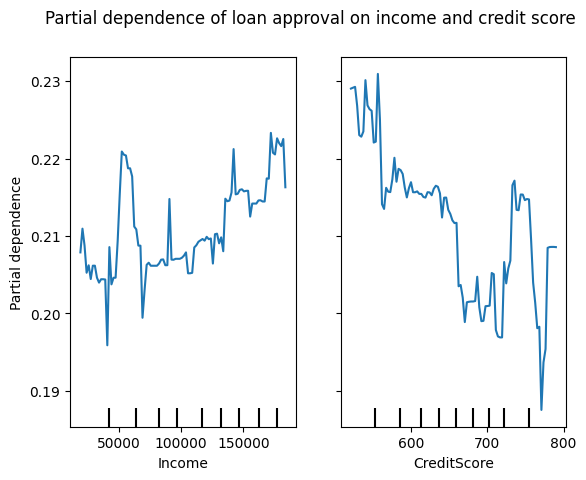

In [ ]:
features = ['Income', 'CreditScore']
display = PartialDependenceDisplay.from_estimator(model, X_train, features)
display.figure_.suptitle("Partial dependence of loan approval on income and credit score")
display.figure_.subplots_adjust(hspace=0.3)


#1a - The PDP of income suggests that as income increases, there is generally a higher probability of loan approval. However, the PDP of CreditScore suggests that as credit score increases, there is generally a lower probability of loan approval. The PDP of Income seems to be generally linear increasing, while the PDP of CreditScore is generally inverse and is linear decreasing.
#1b -  Yes, there are evidences of subgroup behaviors that differ from the population. One example is the $50,000 data value, where the PDP graph diverges from linear increasing to a trough near the $50,000 data value. This can be due to interactions of income with other features and/or noise within the data. Another subgroup is the income shortly after $50,000 where there is a peak. This again can be due to noise or income interacting with other features in the dataset.

correlation = X_train['CreditScore'].corr(X_train['Balance'])
print(correlation)

#1c - The correlation for CreditScore and Balance is very low, as it is .004. This means that they are not correlated. If they were correlated, they could potentially cover the impact of each feature (at least in isolation) on the loan approval probability. Since they are not correlated, it means that the PDP's of each are unique and are not similar, and do not have the same effect to the probability of loan approval.

**Question 2: Feature Importance** <br>
**(a - 1pt)** - Demonstrate a ranked list of all features based on importance (use any method you want). <br>
**(b - 1pt)** - What are some general statements you can make about the ranked list of feature importance?<br>
**(c - 1pt)** - IsFemale is a categorical feature, what statements/learnings can you infer from the importance given to it by your method?

In [ ]:
import shap
import numpy as np

explainer = shap.TreeExplainer(model.best_estimator_)
shap_values = explainer(X_train)

shap_sum = np.abs(shap_values.values).mean(axis=0)
feature_importance = pd.Series(shap_sum, index=X_train.columns).sort_values(ascending=False)

print(feature_importance)

#2a - Shown in output below.
#2b - The model is most impacted by the number of products used for the purpose of loan approval. This is the most influential of all the features in the model. The age of the person and then being female are the second and third most impactful features to the model, followed by the balance in the account and being Hispanic. Besides these features, the rest of the features are not nearly as impactful to the model as compared with the first five.
#2c - The IsFemale feature is the third most impactful feature to the model, we can infer that gender is a crucial factor that the model uses to predict loan approval. Due to the model's reliance on gender, we can infer that this could potentially mean the model has gender bias.

NumOfProducts    1.006755
PersonAge        0.797777
IsFemale         0.296193
Balance          0.173073
IsHispanic       0.169293
CreditScore      0.068244
Cred_Bal_Sal     0.049895
Income           0.047324
ClientAge        0.039135
Bank_Bal_Sal     0.035039
HasCrCard        0.032721
dtype: float32


**Question 3: Shapley Values** <br>
**(a - 1pt)** - Use Shap (library/method of your choosing) to return the top 3 features with corresponding Shapley Values for x0 (below). <br>
**(b - 1pt)** - Depending on the Shap Library/method you selected, what is a possible problem/error that may be present as you interpret your results?<br>
**(c - 1pt)** - Compare your local explanations with the models global explanation (hint: use PDP or Feature imporance), compare the results and explain them to your end stakeholder.

In [ ]:
##out of sample data for question 3
x0 = pd.DataFrame([[767.0,34.0,5.0,162351.55,3,1,122960.98,0,0,719.598899,1.078859]], columns = X_train.columns)
x0

,CreditScore,PersonAge,ClientAge,Balance,NumOfProducts,HasCrCard,Income,IsHispanic,IsFemale,Cred_Bal_Sal,Bank_Bal_Sal
0,767.0,34.0,5.0,162351.55,3,1,122960.98,0,0,719.598899,1.078859


In [ ]:
##model predict on x0
model.predict(x0)

array([1])

NumOfProducts 3.4204504
PersonAge -0.7436859
IsFemale -0.27412963
-0.02398185321299084


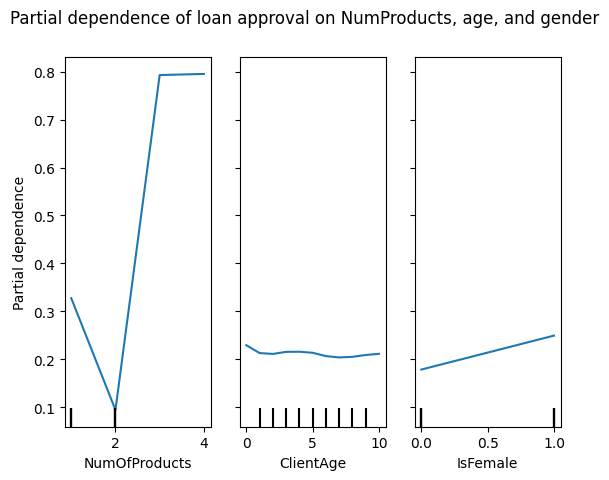

In [ ]:
import shap

explain = shap.Explainer(model.best_estimator_)
shap_values = explain(x0)
shap_valuesx0 = shap_values[0]

top_features = np.argsort(-np.abs(shap_valuesx0.values))[:3]
for i in top_features:
    print(x0.columns[i], shap_valuesx0.values[i])

features1 = ['NumOfProducts', 'ClientAge', 'IsFemale']
display = PartialDependenceDisplay.from_estimator(model, X_train, features1)
display.figure_.suptitle("Partial dependence of loan approval on NumProducts, age, and gender")
display.figure_.subplots_adjust(hspace=0.3)

correlation = X_train['NumOfProducts'].corr(X_train['IsFemale'])
print(correlation)

#3a - Shown in output below.
#3b - A possible problem in the interpretation of these results is how much the Shapley values are impacted by the scale of the results. In general, Shapley values are sensitive to the scale of each of the features. Since, for example, client age and income are not on the same scale, this may impact the corresponding Shapley values and may lead to error in the interpretation of the results.
#3c - The PDP below (the global explanation) showcases the impact of number of products, age, and gender on all of the probabilities of loan approval. The Shapley results (the local explanation) below are listed for these three features. For the number of products, the Shapley values indicate that this is the most impactful feature to the model, as it contributes a value of 3.42 units towards the model's ability to approve the loan, with the x0 data. The PDP suggests something similar, where the impact of the number of products increases drastically after 2. This is followed by the Shapley values for age, which is a value of -.74, suggesting that at age 34 (x0), it decreases the loan approval prediction by 0.74 units on the log-odds scale. The global explanation shows something similar, where the graph starts to decrease after the 35-40 age range. Finally, the gender value from Shapley is -.27, which indicate that at the x0 data point (which is not female), being female decreases the prediction of loan approval by about 0.27 units. The PDP shows that in general, being female increases the odds of being approved.

**Question 4: Rule Based Explanations** <br>
**(a - 1pt)** - Use Anchors to generate a scoped rules explanation for x1 (below). <br>
**(b - 1pt)** - Explain the results to your end Stakeholder (i.e. Percision and Coverage)<br>
**(c - 1pt)** - Compare your rules to the over all Global performance of model and explain to your stakeholder.

In [ ]:
##out of sample data for question 4
x1 = pd.DataFrame([[583.0,71.0,9.0,117.65,1,1,48502.95,1,1,.964651,.418464]], columns = X_train.columns)
x1


,CreditScore,PersonAge,ClientAge,Balance,NumOfProducts,HasCrCard,Income,IsHispanic,IsFemale,Cred_Bal_Sal,Bank_Bal_Sal
0,583.0,71.0,9.0,117.65,1,1,48502.95,1,1,0.964651,0.418464


In [ ]:
##model predict on x1
model.predict(x1)

array([0])

In [ ]:
from alibi.explainers import AnchorTabular

explainer = AnchorTabular(lambda x: model.predict(x), feature_names=X_train.columns)
explainer.fit(X_train.values, disc_perc=[25, 50, 75])

explanation = explainer.explain(x1.values[0])

print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)
print('Coverage: %.2f' % explanation.coverage)

#4a - shown in output.
#4b - The results showcase that a person who is not Hispanic, has a credit to salary ratio above 1, holds 2 products or less, has a balance at about $120,784 or less, and an age above 5 years old will result in the loan prediction being correct 96% of the time. This criteria represents the anchors for this instance, and the .96 precision value mean that when these conditions are met, the model prediction is correct 96% of the time. The coverage of .04 means that these conditions apply to 4% of the instances of the dataset.
#4c - For the features with both a global explainer shown above and anchors shown below (NumOfProducts and ClientAge), the rules are consistent across the local and global explanations. The x1 instance predicts the loan being denied, and the anchor (local explainer) for this instance has an age over 5 and a NumOfProducts less than 2. This is consistent with the PDP (global explainer), where the NumOfProducts having a value greater than 2 increases the probability of loan approval drastically, while being 2 or lower decreases the probability of loan approval. The PDP for ClientAge is more varied, where there is an increased probability after the age of 30, but decreased probability after the age of 50. The anchor simply states the age being greater than 5, and there obviously are a number of instances greater than the age of 5 (5 to 30, for example) where the PDP (global) indicates the probability of loan approval being low, which is consistent with the anchor.

Anchor: IsHispanic > 0.00 AND Cred_Bal_Sal > 0.00 AND Income <= 116893.87 AND NumOfProducts <= 2.00
Precision: 0.95
Coverage: 0.09


**Question 5: Counter Factuals** <br>
**(a - 1pt)** - Use a method of your choosing (i.e. DiCE or Alibi) to generate a counterfactual for x2 (below). <br>
**(b - 1pt)** - Explain the rusults to the loan officer (not the loan applicant) <br>
**(c - 1pt)** - Outline a plan for the loan applicant to become approved next time they apply.

In [ ]:
#data for question 5
x2 = pd.DataFrame([[727.0,50.0,9.0,98738.61,1.0,1,100240.20,0,0,716.109599,100.985]], columns = X_train.columns)
x2


,CreditScore,PersonAge,ClientAge,Balance,NumOfProducts,HasCrCard,Income,IsHispanic,IsFemale,Cred_Bal_Sal,Bank_Bal_Sal
0,727.0,50.0,9.0,98738.61,1.0,1,100240.2,0,0,716.109599,100.985


In [ ]:
target = model.predict(x2)
target

array([1])

In [ ]:
X_train.head(1)

,CreditScore,PersonAge,ClientAge,Balance,NumOfProducts,HasCrCard,Income,IsHispanic,IsFemale,Cred_Bal_Sal,Bank_Bal_Sal
0,585.0,25.0,1.0,0.0,2.0,0,40260.4,1,0,0.0,0.0


In [ ]:
X_train.IsHispanic.astype("category")
X_train.IsHispanic = X_train.IsHispanic.astype("category")

X_train.IsFemale.astype("category")
X_train.IsFemale = X_train.IsFemale.astype("category")

x2.IsHispanic.astype("category")
x2.IsHispanic = x2.IsHispanic.astype("category")

x2.IsFemale.astype("category")
x2.IsFemale = x2.IsFemale.astype("category")

In [ ]:
x2.dtypes


CreditScore       float64
PersonAge         float64
ClientAge         float64
Balance           float64
NumOfProducts     float64
HasCrCard           int64
Income            float64
IsHispanic       category
IsFemale         category
Cred_Bal_Sal      float64
Bank_Bal_Sal      float64
dtype: object

In [ ]:
model1

RandomForestClassifier()

In [ ]:
import dice_ml
from dice_ml.utils import helpers
from sklearn.model_selection import train_test_split

X_train.dtypes

d = dice_ml.Data(dataframe=X_train.join(y_train),
                 continuous_features=['CreditScore', 'PersonAge', 'ClientAge','Balance', 'NumOfProducts', 'HasCrCard', 'Income', 'Cred_Bal_Sal', 'Bank_Bal_Sal'],
                 outcome_name='Approved')

backend = "sklearn"
m = dice_ml.Model(model=model1,
                   backend='sklearn')

exp = dice_ml.Dice(d,m, method = 'random')
exp
instance = x2
dice_exp = exp.generate_counterfactuals(X_train.head(1), total_CFs=4, desired_class="opposite")

dice_exp.visualize_as_dataframe(show_only_changes=True)



100%|██████████| 1/1 [00:01<00:00,  1.76s/it]

Query instance (original outcome : 0)


,CreditScore,PersonAge,ClientAge,Balance,NumOfProducts,HasCrCard,Income,IsHispanic,IsFemale,Cred_Bal_Sal,Bank_Bal_Sal,Approved
0,585.0,25.0,1.0,0.0,2.0,0,40260.398438,NaN,NaN,0.0,0.0,0



Diverse Counterfactual set (new outcome: 1)


,CreditScore,PersonAge,ClientAge,Balance,NumOfProducts,HasCrCard,Income,IsHispanic,IsFemale,Cred_Bal_Sal,Bank_Bal_Sal,Approved
0,-,-,-,153691.2,3.7,-,-,1.0,0.0,-,-,1.0
1,-,-,-,-,3.4,-,-,1.0,0.0,-,7179.4,1.0
2,-,-,-,109354.9,2.9,-,-,1.0,0.0,-,-,1.0
3,-,-,-,-,3.3,-,-,nan,0.0,-,-,1.0


In [ ]:
#5a: Shown in output above

#5b - The results for the counterfactual change each time, but based on the current CF results, it shows that the current applicant info above will lead this applicant's loan to be rejected. However, if all the other factors stay the same, by increasing the number of products held from 2 to 4, one will be approved for a loan (physically can't have 3.6 products, as the current CF suggests). If one increases their balance from $0 to $234,073.40 and above, and also increases their number of products held to 4 (based on dependence of NumOfProducts taken from PDP plot), they will be approved. If one is 59.6 years old, has the same input values, and decreases their number of products to 1, they will also be approved. In sum, it shows the loan officer that a higher age and higher balance generally means the loan will be approved for the applicant. An increase in products held also generally lead to a higher chance of approval.
#5c - To be approved next time, one should increase their number of products held, or increase the balance in their account. This will lead to the loan being approved for the applicant (the applicant cannot increase their own age, despite what the counterfactual above shows).

**Bonus (1pt): Play the role of regulator**
* you've gotten an anonymous tip that the model used to approve loans is biased (however you have no info on how)
* build a case for bias in the model by generating quantitative evidence and a qualitative explanation of why the analysis supports the case for bias
* feel free to use any of the methods mentioned in class, or any others of your choosing (including statistical inference, etc)
* It's also an acceptable response to demonstrate that there is no bias
* In this case assume you don't have access to the training data

*Answer is below


In [ ]:
!pip install aif360

from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric

In [ ]:
# Bonus
aif360_dataset = StandardDataset(X_test.join(y_test),
                                 label_name='Approved',
                                 favorable_classes=[1],
                                 protected_attribute_names=['IsHispanic'],
                                 privileged_classes=[['2']])  # Assuming 'Male' is considered privileged in this context

# Calculate fairness metrics
metric = BinaryLabelDatasetMetric(aif360_dataset,
                                  unprivileged_groups=[{'IsHispanic': 1}],
                                  privileged_groups=[{'IsHispanic': 0}])

disparate_impact = metric.disparate_impact()
print(f"Disparate Impact (Ratio of positive outcomes, 1 is ideal): {disparate_impact}")

# BONUS QUESTION - I used the AI Fairness 360 library for this question. Through this library, I calculated the bias against the IsHispanic input feature. The value generated, comparing Hispanic applicants with non-Hispanics, was about 0.61. This means that Hispanic applicants are 61% as likely as non-Hispanic applicants to be approved for a loan. Basically, for every 100 non-Hispanic applicants that get approved, only 61 Hispanic applicants are approved. As a result, one could state that this model is inherently biased against Hispanics, at least based on the AI Fairness 360 library.

Disparate Impact (Ratio of positive outcomes, 1 is ideal): 0.6088755428312086
